In [ ]:
import os
# Find the latest version of spark 3.2  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.2.2'
spark_version = 'spark-3.<enter version>'

os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

In [3]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("illegal_postings_311").getOrCreate()

In [4]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://2u-data-curriculum-team.s3.amazonaws.com/dataviz-classroom/v1.1/22-big-data/day_1/illegal_postings_311.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("illegal_postings_311.csv"), header=True, inferSchema=True, timestampFormat="yyyy/MM/dd HH:mm:ss")

# Show DataFrame
df.show()

+------+-------------------+--------------------+--------------------+------+--------------------+------------------+----------------+--------------------+--------------------+--------------------+-------------+-------------------+--------------------+---------------+---------------+-----------------+--------------------+-------+---------+---------------------+------------------------+----------------------------+----------------------+--------------------------------------------+-----------------------------------+--------------------------------------+----------------------------------+----------------------------------------------------+---------------------------+------------------+---------------------------------+-------------+
|CaseID|             Opened|              Closed|             Updated|Status|        Status Notes|Responsible Agency|        Category|        Request Type|     Request Details|             Address|       Street|Supervisor District|        Neighborhood|Poli

In [5]:
# Import date time functions
from pyspark.sql.functions import month, year

In [6]:
# Create a new DataFrame with the column Year, use Opened column
df.select(year(df["Opened"])).show()

+------------+
|year(Opened)|
+------------+
|        2009|
|        2010|
|        2010|
|        2010|
|        2010|
|        2010|
|        2010|
|        2010|
|        2010|
|        2010|
|        2010|
|        2010|
|        2010|
|        2010|
|        2010|
|        2010|
|        2010|
|        2010|
|        2010|
|        2010|
+------------+
only showing top 20 rows



In [7]:
# Save the year as a new column
df = df.withColumn("year", year(df['Opened']))
df.show()

+------+-------------------+--------------------+--------------------+------+--------------------+------------------+----------------+--------------------+--------------------+--------------------+-------------+-------------------+--------------------+---------------+---------------+-----------------+--------------------+-------+---------+---------------------+------------------------+----------------------------+----------------------+--------------------------------------------+-----------------------------------+--------------------------------------+----------------------------------+----------------------------------------------------+---------------------------+------------------+---------------------------------+-------------+----+
|CaseID|             Opened|              Closed|             Updated|Status|        Status Notes|Responsible Agency|        Category|        Request Type|     Request Details|             Address|       Street|Supervisor District|        Neighborhood

In [8]:
# Find the total Opened cases per year
averages = df.groupBy("year").count()
averages.orderBy("year").select("year", "count").show()

+----+-----+
|year|count|
+----+-----+
|null|  591|
|2008|  301|
|2009|  522|
|2010|  984|
|2011| 1499|
|2012| 2908|
|2013| 7913|
|2014| 6469|
|2015|10087|
|2016| 7621|
|2017| 5522|
|2018| 4920|
|2019| 8235|
|2020|14087|
|2021|12038|
|2022|  648|
+----+-----+



In [9]:
# Import the summarized data to a pandas DataFrame for plotting
# Note: If your summarized data is still too big for your local memory then your notebook may crash
import pandas as pd
pandas_df = averages.orderBy("year").select("year", "count").toPandas()
pandas_df.head()

,year,count
0,NaN,591
1,2008.0,301
2,2009.0,522
3,2010.0,984
4,2011.0,1499


In [11]:
# Clean the data by dropping NaN values and rename the column "count" to "Cases"
pandas_df = pandas_df.dropna()
pandas_df = pandas_df.rename(columns={"count": "Cases"})
pandas_df.head()

,year,Cases
1,2008.0,301
2,2009.0,522
3,2010.0,984
4,2011.0,1499
5,2012.0,2908


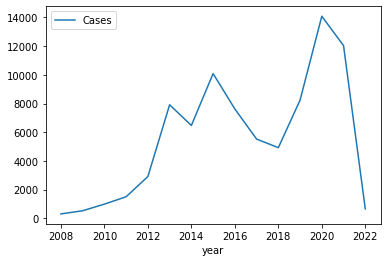

In [12]:
# Plot the year and Cases
%matplotlib inline
pandas_df.plot("year", "Cases")